In [4]:
import glob
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

### FUNCTIONS

In [5]:
def outlier_indices(data):
    q1 = np.percentile(data, 25, method='midpoint')
    q3 = np.percentile(data, 75, method='midpoint')
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    upper_outliers = np.where(data >= upper)[0]
    lower_outliers = np.where(data <= lower)[0]
    outlier_index_list = list(upper_outliers) + list(lower_outliers)
    
    return outlier_index_list

def remove_outliers(data):
    outliers_removed = []
    
    for i in range(0,len(data)):
        if i not in outlier_indices(data):
            outliers_removed.append(data[i])
            
    return outliers_removed

def bootstrap_ci(group1, group2):
    
    ####################################################
    #sample from pooled 1000 times
    n1 = len(group1)
    n2 = len(group2)
    
    bootstrap_sample1 = []
    bootstrap_sample2 = []
    
    for i in range(1000):
        sample1 = []
        sample2 = []
        index1 = np.random.choice(range(0,n1),n1,replace=True)
        index2 = np.random.choice(range(0,n2),n2,replace=True)
        sample1 = np.array(group1)[index1]
        sample2 = np.array(group2)[index2]
        bootstrap_sample1.append(sample1)
        bootstrap_sample2.append(sample2)
        
    diff_list = []
    for i in range(1000):
        mean1 = np.mean(bootstrap_sample1[i])
        mean2 = np.mean(bootstrap_sample2[i])
    
        diff = mean2 - mean1
        diff_list.append(diff)
    

    diff_list.sort()


    perc_025 = diff_list[24]
    perc_975 = diff_list[974]

    
    return perc_025, perc_975

def error_bars(data):

    bootstrap_samples = []

    for i in range(1000):
    #create 1000 bootstrap samples
        n = len(data)
        index = np.random.choice(range(0,n),n,replace=True)
        sample = np.array(data)[index]
        bootstrap_samples.append(sample)
    
    #calculate 1000 means
    means = []
    for sample in bootstrap_samples:
        mean = np.mean(sample)
        means.append(mean)

    #sort means list
    means.sort()
    
    #choose 25th value, choose 975th value
    perc_025 = means[24]
    perc_975 = means[974]

    
    return perc_025, perc_975

In [6]:
#methods = ['coh','ciplv','imcoh','wpli2']
methods = ['gpdc', 'ddtf', 'psgp']

path_nc_files = '/scratch/nc_outputs'  

vn = ['fusiform-rh', 'fusiform-lh', 'lingual-rh', 'lingual-lh', 'cuneus-rh', 'cuneus-lh', 'lateraloccipital-rh', 'lateraloccipital-lh']

### CALCULATING MEANS, EYES-CLOSED (EC)

In [8]:
means_dict_ec = {}

for method in methods:

    #xarrays = glob.glob(f"{path_nc_files}/{method}/*_{method}_EC.nc") 
    xarrays = glob.glob(f"{path_nc_files}/{method}/*_{method}_EC.nc")
    
    subjects = []
    for array in xarrays:
        #subject = array.split('/')[9].split('_')[0]
        subject = array.split('/')[4].split('_')[0]
        subjects.append(subject)
                
    xarrays_combined = []
    for array in xarrays:
        xarrays_combined.append(xr.open_dataarray(array))
    
    xarrays_combined = xr.concat(xarrays_combined, pd.Index(subjects, name="subjects"))
    xarrays_combined_vn = xarrays_combined.sel(region1 = vn, region2 = vn)

    mean_list_ec = []
    
    for subject in subjects:
        sub_data = xarrays_combined_vn.sel(subjects=subject)
        mean = sub_data.mean(dim=["bootstrap_samples","region1","region2","frequencies"]).values
        mean_list_ec.append(float(mean))

    means_dict_ec[method] = mean_list_ec

### CALCULATING MEANS EYES OPEN (EO)

In [9]:
means_dict_eo = {}

for method in methods:
    
    xarrays = glob.glob(f"{path_nc_files}/{method}/*_{method}_EO.nc")
    
    subjects = []
    for array in xarrays:
        subject = array.split('/')[9].split('_')[0]
        #subject = array.split('/')[4].split('_')[0]
        subjects.append(subject)
                
    xarrays_combined = []
    for array in xarrays:
        xarrays_combined.append(xr.open_dataarray(array))
    
    xarrays_combined = xr.concat(xarrays_combined, pd.Index(subjects, name="subjects"))
    xarrays_combined_vn = xarrays_combined.sel(region1 = vn, region2 = vn)

    mean_list_eo = []
    
    for subject in subjects:
        sub_data = xarrays_combined_vn.sel(subjects=subject)
        mean = sub_data.mean(dim=["bootstrap_samples","region1","region2","frequencies"]).values
        mean_list_eo.append(float(mean))
    
    means_dict_eo[method] = mean_list_eo

### CALCULATING EFFECT SIZES (COHEN'SD)

In [11]:
cohens_d_dict = {}

for method in methods:
    
    n_ec = len(means_dict_ec[method])
    std_ec = np.std(means_dict_ec[method])
    mean_ec = np.mean(means_dict_ec[method])

    n_eo = len(means_dict_eo[method])
    std_eo = np.std(means_dict_eo[method])
    mean_eo = np.mean(means_dict_eo[method])
    

    pooled_sd = np.sqrt(((n_ec - 1) * (std_ec ** 2) + (n_eo - 1)* (std_eo ** 2))/( n_ec + n_eo - 2))
    cohens_d = (mean_ec - mean_eo)/pooled_sd
    cohens_d_dict[method] = cohens_d

### STATISTICAL ANALYSES

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

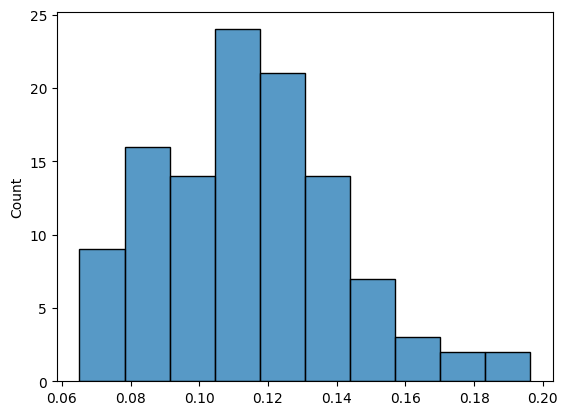

In [12]:
#EXAMINING DISTRIBUTIONS

import seaborn as sns

#sns.histplot(means_dict_eo['coh'])

In [13]:
#Remove outliers
for method in methods:
    means_dict_ec[method] = remove_outliers(means_dict_ec[method])
    means_dict_eo[method] = remove_outliers(means_dict_eo[method])

In [ ]:
##CHECK FOR OUTLIERS (EFFECTIVE CONNECTIVITY)
for method in methods:
    print(method)
    print("EC")
    for val in means_dict_ec[method]:
        if val > 1:
            print(val)

In [ ]:
#CHECK FOR OUTLIERS (EFFECTIVE CONNECTIVITY)
for method in methods:
    print(method)
    print("EO")
    for val in means_dict_eo[method]:
        if val > 1:
            print(val)

In [14]:
##CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(means_dict_ec[method]))

coh 112
ciplv 109
imcoh 107
wpli2 108


In [15]:
##CHECK SAMPLE SIZES OF DICTIONARIES
for method in methods:
    print(method, len(means_dict_eo[method]))

coh 110
ciplv 105
imcoh 108
wpli2 102


In [16]:
#95% CONFIDENCE INTERVALS USING BOOTSTRAP RE-SAMPLING

ci_dict = {}

for method in methods:
    ci_dict[method] = bootstrap_ci(means_dict_ec[method], means_dict_eo[method])

In [17]:
#CALCULATING ERROR BARS FOR GRAPHING

graph_ci_eo_dict = {}

for method in methods:
    lower_limit = error_bars(means_dict_eo[method])[0]
    upper_limit = error_bars(means_dict_eo[method])[1]
    err = upper_limit - lower_limit
    graph_ci_eo_dict[method] = err

graph_ci_ec_dict = {}

for method in methods:
    lower_limit = error_bars(means_dict_ec[method])[0]
    upper_limit = error_bars(means_dict_ec[method])[1]
    err = upper_limit - lower_limit
    graph_ci_ec_dict[method] = err

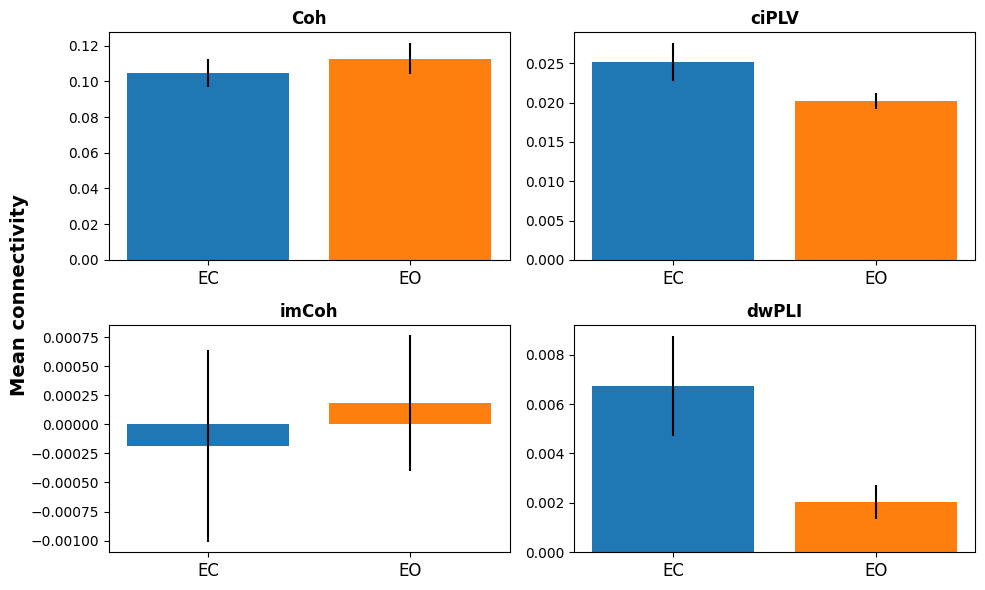

In [19]:
#GRAPHING
"""
fig, axes = plt.subplots(2,2,figsize=(10,6))


for method, ax in zip(methods, axes.ravel()):

    mean_ec = np.mean(means_dict_ec[method])

    mean_eo = np.mean(means_dict_eo[method])
    
    ax.bar(0, mean_ec, yerr=graph_ci_ec_dict[method])
    ax.bar(1, mean_eo, yerr=graph_ci_eo_dict[method])
    ax.set_xticks([0,1])
    ax.set_xticklabels(('EC','EO'),fontsize=12)

axes[0][0].set_title('Coh',fontweight='bold')
axes[0][1].set_title('ciPLV',fontweight='bold')
axes[1][0].set_title('imCoh',fontweight='bold')
axes[1][1].set_title('dwPLI',fontweight='bold')

fig.supylabel('Mean connectivity',fontsize=14,fontweight='bold')
fig.tight_layout()
plt.savefig('/scratch/figures/real_func_means.png',dpi=300)"""

In [ ]:
"""fig, axes = plt.subplots(1,3,figsize=(10,6))


for method, ax in zip(methods, axes.ravel()):

    mean_ec = np.mean(means_dict_ec[method])

    mean_eo = np.mean(means_dict_eo[method])
    
    ax.bar(0, mean_ec, yerr=graph_ci_ec_dict[method])
    ax.bar(1, mean_eo, yerr=graph_ci_eo_dict[method])
    ax.set_xticks([0,1])
    ax.set_xticklabels(('EC','EO'),fontsize=12)

axes[0].set_title('gPDC',fontweight='bold')
axes[1].set_title('dDTF',fontweight='bold')
axes[2].set_title('pSGP',fontweight='bold')

fig.supylabel('Mean connectivity',fontsize=14,fontweight='bold')
fig.tight_layout()
plt.savefig('/scratch/figures/real_eff_means.png',dpi=300)"""